<h1>Mod 3 Final Project </h1>

<p> Student name: Nicholas Donovan <br>
Student pace: Part-Time <br>
Scheduled project review date/time: 11/27/19 12:30pm <br>
Instructor name: Abhineet Kulkarni <br>
Blog post URL:  https://medium.com/@nicodonovan/hypothesis-testing-50d180a935a9?sk=2d028669a57634d33b4d7e8b612b7224 <br>
Video Walkthrough URL: </p>

We will be using hypothesis testing and statistical analysis techniques to explore the following questions for Northwind companies. 

> 1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
> 2. Does the region from which an employee is based have an effect on quantities ordered?
> 3. Do orders without meat/poultry have a higher revenue than orders with meat/poultry?
> 4. Does shipping from the same region as the supplier have an effect on freight? 

In [43]:
# SQL tools
import sqlite3 

# Exploratory Data Analysis (EDA)
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# hypothesis testing
from scipy import stats
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower

In [104]:
# functions

def welch_t(a, b, two_sided=False):
    # t-statistic
    t = np.abs((a.mean() - b.mean())/np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size))
    # degrees of freedom
    s1 = a.var(ddof=1)
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    df = ((s1/n1 + s2/n2)**2) / ((s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1))
    # p-value
    p = 1-stats.t.cdf(t, df)
    
    print("T-statistic:", t)
    print("Degrees of Freedom:", df)
    
    if two_sided:
        print("P-value:", 2*p) 
    else: 
        print("P-value:", p)
    
    if p < 0.05:
        print("Decision: Reject Null Hypothesis")
    else:
        print("Decision: Fail to Reject Null Hypothesis")


def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

![title](Northwind_ERD_updated.png)

In [9]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

<h2> 1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? </h2>

> **Control**: Orders without a discount
>
> **Treatment**: Orders with a discount
>> $H_{0}:$ Discounts do not have an effect on the quantity of a product in an order. $\mu_0  = \mu_1 $
>
>> $H_{1}:$ Discounts have an effect on the quantity of a product in an order. $\mu_0 \neq \mu_1 $
>
> Significance Level: $\alpha = 0.05$ (Probability of a Type I error)

Based on the schema above, all of the necessary data is contained within the OrderDetail table. In particular, we will be focusing on quantity ordered and discount given. Our control group will be quantities of orders without a discount, while the treatment group with the quantities of orders with a discount.

In [145]:
#  Treatment (orders with a discount)
cur.execute('''SELECT Quantity, Discount FROM OrderDetail WHERE Discount >0;''')
treatment1 = pd.DataFrame(cur.fetchall())
treatment1.columns = [x[0] for x in cur.description]
treatment1.info() # checks for correct data type and any null values
treatment1.describe() # overview of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
Quantity    838 non-null int64
Discount    838 non-null float64
dtypes: float64(1), int64(1)
memory usage: 13.2 KB


,Quantity,Discount
count,838.000000,838.000000
mean,27.109785,0.144439
std,20.771439,0.071808
min,1.000000,0.010000
25%,12.000000,0.100000
50%,20.000000,0.150000
75%,36.000000,0.200000
max,130.000000,0.250000


In [146]:
# Control (orders without a discount)
cur.execute('''SELECT Quantity, Discount FROM OrderDetail WHERE Discount == 0;''')
control1 = pd.DataFrame(cur.fetchall())
control1.columns = [x[0] for x in cur.description]
control1.info() # checks for correct data type and any null values
control1.describe() # overview of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 2 columns):
Quantity    1317 non-null int64
Discount    1317 non-null float64
dtypes: float64(1), int64(1)
memory usage: 20.7 KB


,Quantity,Discount
count,1317.000000,1317.0
mean,21.715262,0.0
std,17.507493,0.0
min,1.000000,0.0
25%,10.000000,0.0
50%,18.000000,0.0
75%,30.000000,0.0
max,130.000000,0.0


Based on the initial data exploration, we can see that Northwind currently offers discounts between 1 and 25%. Fortunately there are no missing data and they all have the correct data types. We can proceed to data visualization.


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


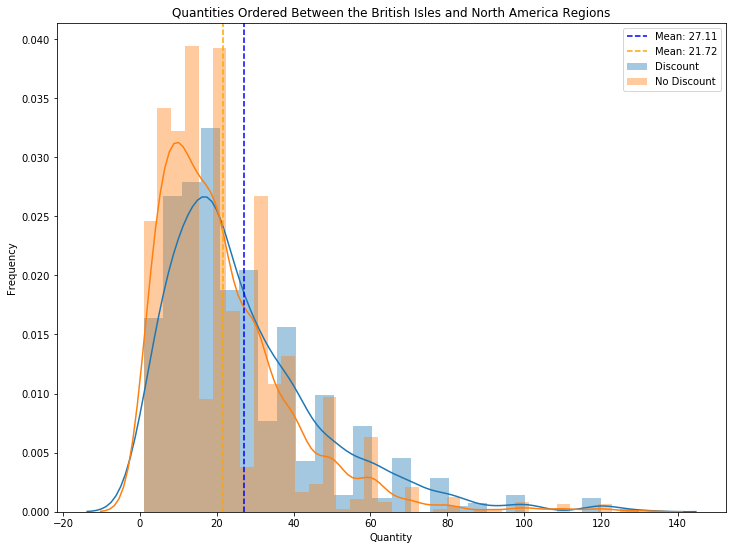

In [147]:
plt.figure(figsize=(12,9))
sns.distplot(treatment1.Quantity, label="Discount")
sns.distplot(control1.Quantity, label="No Discount")
plt.title("Quantities Orders with and without Discount")
plt.axvline(treatment1.Quantity.mean(), label="Mean: "+str(round(treatment1.Quantity.mean(), 2)), color="blue", linestyle='--')
plt.axvline(control1.Quantity.mean(), label="Mean: " +str(round(control1.Quantity.mean(), 2)), color="orange", linestyle='--')
plt.title("Quantities Ordered Between the British Isles and North America Regions")
plt.ylabel("Frequency")
plt.legend()

From the histogram, we can see that the data does not seem to be normally distributed. We will use the Kolmogorov-Smirnov test for normality to confirm this observation.

In [148]:
# Kolmogorov-Smirnov test for Discounted Sample
stats.kstest(treatment1.Quantity, 'norm')

KstestResult(statistic=0.9724765983620833, pvalue=0.0)

In [149]:
# Kolmogorov-Smirnov test for Non-Discounted Sample
stats.kstest(control1.Quantity, 'norm')

KstestResult(statistic=0.9673789492970751, pvalue=0.0)

The p-values for both of our samples are below 0.05, meaning we can reject the null hypothesis and conclude that our samples' distributions are not identical to a normal distribution. However, since we are working with such a large sample size (n > 800), we can still move on to check variance and perform a T-test. 

In [150]:
# Levene Test
if stats.levene(control1.Quantity, treatment1.Quantity)[1]<0.05:
    print('Input samples are not from populations with equal variances.')
else:
    print('Input samples are from populations with equal variances.')

Input samples are not from populations with equal variances.


We used Levene's Test to determine whether or not the variance is equal to the p-value. This will help guide our decision making on which type of T-test to deploy. Since our variances are not equal, we shall use Welch's T-test (Two-Sample, Two-Tailed).

In [151]:
welch_t(control1.Quantity, treatment1.Quantity, two_sided=True)

T-statistic: 6.239069142123973
Degrees of Freedom: 1561.7678231942148
P-value: 5.656413115673331e-10
Decision: Reject Null Hypothesis


In [152]:
effect_size = Cohen_d(control1.Quantity, treatment1.Quantity)
print("Effect size:", effect_size)

# small = 0.2
# medium = 0.5
# large = 0.8

Effect size: -0.2862724481729282


In [44]:
# Power
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=0.2862724481729282, nobs1=838, alpha=.05)

# IF power >= .8 - accept/reject null hypotheses
# IF power < .8 - resample or larger sample

1.0

**Results**: With a P-value of less than our established alpha of 0.05, and a power of greater than 0.8, we can successfully reject the null hypothesis and accept the alternative that orders with a discount have a statistically significant effect on quantity ordered.

Having accepted the alternative hypothesis, we will now further inspect to see at what level(s) of discount is the effect most significant. We felt that using an ANOVA table would be the most efficient way to compare the effectivness of each individual discount level. We used the no discount group as the control.

In [53]:
# separate discount rates
zero = df_nd
five = df_d.loc[df_d['Discount'] == 0.05]
ten = df_d.loc[df_d['Discount'] == 0.10]
fifteen = df_d.loc[df_d['Discount'] == 0.15]
twenty = df_d.loc[df_d['Discount'] == 0.20]
twentyfive = df_d.loc[df_d['Discount'] == 0.25]

rates = pd.DataFrame()

for group, name in [(zero, 'zero'), (five, 'five'), (ten, 'ten'), (fifteen, 'fifteen'), (twenty, 'twenty'), (twentyfive, 'twentyfive')]:
    group = group.sample(n=100, random_state=10)
    rates[name] = group.Quantity.reset_index(drop=True)
rates.head()

,zero,five,ten,fifteen,twenty,twentyfive
0,6,12,20,24,40,20
1,9,28,18,70,55,2
2,40,24,18,40,6,12
3,12,8,15,10,30,20
4,14,2,10,16,45,30


In [54]:
formula = 'zero ~ five + ten + fifteen + twenty + twentyfive'
lm = ols(formula, rates).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq    df         F    PR(>F)
five            0.098743   1.0  0.000494  0.982311
ten           132.612105   1.0  0.663715  0.417311
fifteen       242.871017   1.0  1.215553  0.273050
twenty        840.903201   1.0  4.208665  0.043000
twentyfive      9.420252   1.0  0.047148  0.828573
Residual    18781.465651  94.0       NaN       NaN


To interpret our ANOVA table, the far right column whose values of less than our alpha (0.05) indicate that we can reject the null hypothesis. Thus we can conclude that discount rates of 10, 15 and 20% have a statistically significant effect on quantiyy ordered. Of those, 20% seems to be the most influential. This seems to follow conventional wisdom, until we reach the maximum discount of 25%, which did not have a statistically significant effect. Our recommendation to Northwind would be to target their discounts in the 10-20% range, but never exceeding the 20%. 

<h2> 2. Does the region from which an employee is based have an effect on quantities ordered? </h2>

In [56]:
cur.execute('''select Employee.LastName, Employee.FirstName, Employee.City, Employee.Region, Employee.Title, EmployeeTerritory.TerritoryId
from Employee
join [Order] o on Employee.Id = o.EmployeeId
join OrderDetail on o.Id = OrderDetail.OrderId
join EmployeeTerritory on Employee.Id = EmployeeTerritory.EmployeeId
group by Employee.Id
order by Employee.Region;''')
df_employee = pd.DataFrame(cur.fetchall())
df_employee.columns = [x[0] for x in cur.description]
df_employee

,LastName,FirstName,City,Region,Title,TerritoryId
0,Buchanan,Steven,London,British Isles,Sales Manager,14450
1,Suyama,Michael,London,British Isles,Sales Representative,98104
2,King,Robert,London,British Isles,Sales Representative,95060
3,Dodsworth,Anne,London,British Isles,Sales Representative,55439
4,Davolio,Nancy,Seattle,North America,Sales Representative,19713
5,Fuller,Andrew,Tacoma,North America,"Vice President, Sales",40222
6,Leverling,Janet,Kirkland,North America,Sales Representative,33607
7,Peacock,Margaret,Redmond,North America,Sales Representative,27511
8,Callahan,Laura,Seattle,North America,Inside Sales Coordinator,53404


As you can see above, Northwind has a total of 9 employees either based in London or the Pacific Northwest of the United States. For this experiment, we want to test the hypothesis that will give us more information between the two regions on which employees are based. This could potentially give us more insight into the habits of the customers they serve, as well as performance of employees in that region.

> **Control** : British Isles order Quantities
>
> **Treatment** : North American order Quantities
>
>>$H_{0}:$ Orders placed through the British Isles have the same quantities as orders placed through North America. $\mu_0  = \mu_1 $
>
>> $H_{1}:$ Orders placed through the North American Region do not have the same quantities as orders placed through the British Isles . $\mu_0 \neq \mu_1 $
>
> Significance Level: $\alpha = 0.05$ (Probability of a Type I error)

In [90]:
# Control (Orders placed through British Isles)
cur.execute('''select Employee.Region, OrderDetail.Quantity
from Employee
join [Order] o on Employee.Id = o.EmployeeId
join OrderDetail on o.Id = OrderDetail.OrderId
where Region = "British Isles";''')
control2 = pd.DataFrame(cur.fetchall())
control2.columns = [x[0] for x in cur.description]
control2.info() # checks for correct data type and any null values
control2.describe() # overview of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 2 columns):
Region      568 non-null object
Quantity    568 non-null int64
dtypes: int64(1), object(1)
memory usage: 9.0+ KB


,Quantity
count,568.000000
mean,24.448944
std,19.360067
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,130.000000


In [91]:
control2.head()

,Region,Quantity
0,British Isles,12
1,British Isles,10
2,British Isles,5
3,British Isles,9
4,British Isles,40


In [92]:
# Treatment (Orders placed through North America)
cur.execute('''select Employee.Region, OrderDetail.Quantity
from Employee
join [Order] o on Employee.Id = o.EmployeeId
join OrderDetail on o.Id = OrderDetail.OrderId
where Region = "North America";''')
treatment2 = pd.DataFrame(cur.fetchall())
treatment2.columns = [x[0] for x in cur.description]
treatment2.info() # checks for correct data type and any null values
treatment2.describe() # overview of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 2 columns):
Region      1587 non-null object
Quantity    1587 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.9+ KB


,Quantity
count,1587.000000
mean,23.585381
std,18.900569
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,130.000000


In [93]:
treatment2.head()

,Region,Quantity
0,North America,10
1,North America,35
2,North America,15
3,North America,6
4,North America,15


After separating our data into control and treatment comparison groups, we can see that we have 568 entries for the control, and 1587 entries for the treatment. Both are sufficiently large for hypotheis testing so we can move on to checking the distribution.
<br>
<br>
**Note**: the mean and standard distribution of the control and treatment groups appear to be very similar to each other. Hinting at what the hypothesis testing may reveal. 

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


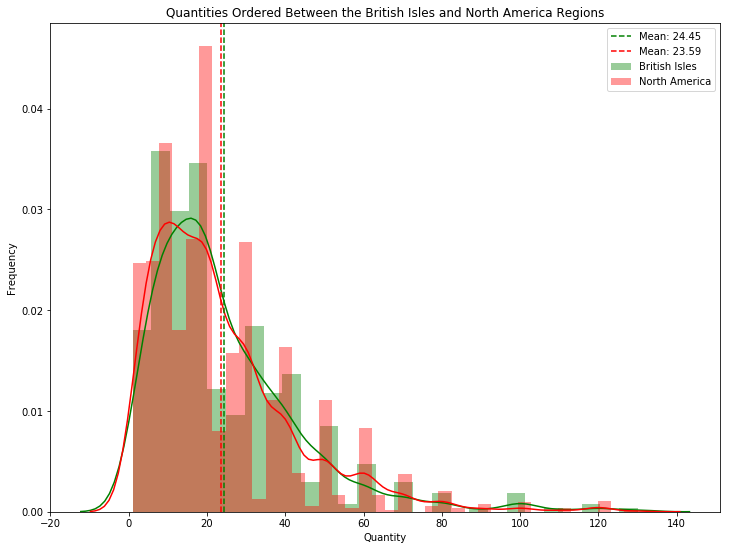

In [99]:
# distribution plot 
plt.figure(figsize=(12,9))
sns.distplot(control2.Quantity, label="British Isles", color="green")
sns.distplot(treatment2.Quantity, label="North America", color="red")
plt.axvline(control2.Quantity.mean(), label="Mean: "+str(round(control2.Quantity.mean(), 2)), color="green", linestyle='--')
plt.axvline(treatment2.Quantity.mean(), label="Mean: " +str(round(treatment2.Quantity.mean(), 2)), color="red", linestyle='--')
plt.title("Quantities Ordered Between the British Isles and North America Regions")
plt.ylabel("Frequency")
plt.legend()

In [100]:
# Kolmogorov-Smirnov test for normality for British Isles
stats.kstest(control2.Quantity, 'norm')

KstestResult(statistic=0.9757627780247079, pvalue=0.0)

In [101]:
# Kolmogorov-Smirnov test for normality for North America 
stats.kstest(treatment2.Quantity, 'norm')

KstestResult(statistic=0.9684281919333583, pvalue=0.0)

The p-values for both of our samples are below 0.05, meaning we can reject the null hypothesis and conclude that our samples' distributions are no identical to a normal distribution. We can also visually confirm using the histogram above. However, since we are working with such a large sample size (n > 500), we can still move on to check variance and perform a T-test. 

In [103]:
# Levene Test
if stats.levene(control2.Quantity,treatment2.Quantity)[1]<0.05:
    print('Input samples are not from populations with equal variances.')
else:
    print('Input samples are from populations with equal variances.')

Input samples are from populations with equal variances.


For these two samples, the variances to equal, meaning we can use the Two-sample Student's T-test (2-Tailed) to check our hypothesis. 

In [105]:
# Student's T-Test (2-Tailed)
stats.ttest_ind(treatment2.Quantity, control2.Quantity)

Ttest_indResult(statistic=-0.928456539361685, pvalue=0.35327487750397335)

In [142]:
# effect size using Cohen's D
effect_size2 = Cohen_d(control2.Quantity, treatment2.Quantity)
print("Effect size:", effect_size2)

# small = 0.2
# medium = 0.5
# large = 0.8

Effect size: 0.045396280249395585


In [112]:
# Power
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=effect_size2, nobs1=500, alpha=.05)

# IF power >= .8 - accept/reject null hypotheses
# IF power < .8 - resample or larger sample

0.11067037226659593

**Results**: With a p-value of 0.353, we can say that we *fail to reject the null hypothesis*. Thus we can assume that the region from which an employee is based should not have an effect on quantity ordered. This conclusion is further verified by the very low effect size (lots of overlap between the two populations). However, the low power indicates that we may not have a large enough sample to come to a firm conclusion. <br>
<br>
This result gives us further insight into the Northwind company. It gives some evidence that employee performance is not effected by the region in which they are employeed and you have consistent performance accross the company. This would point to a strength within the company to maintain consistent performance across continents. 

<h2> 3. Do orders without meat/poultry have a higher revenue than orders with meat/poultry? </h2>

The cultural norms and concerns are shifting as the world becomes more conscious of Global Warming and sustainability. We are testing this hypothesis to see if this has begun to effect the revenue of Northwind and if any change in market strategy should occur.

> **Control** : Revenue from orders with meat/poultry
>
> **Treatment** : Revenue from orders without meat/poultry
>
>>$H_{0}:$ Orders with meat/poultry have the same revenue as orders without meat/poultry. $\mu_0  = \mu_1 $
>
>> $H_{1}:$ Orders without meat/poultry have greater revenue than orders with meat/poultry. $\mu_0 > \mu_1 $
>
> Significance Level: $\alpha = 0.05$ (Probability of a Type I error)

We define revenue as: <br>
*Unit Price * (1 - Discount) * Quantity*

In [69]:
# revenue subtotals for each product category
cur.execute('''SELECT od.OrderId,
                            SUM(CASE WHEN c.CategoryName == 'Beverages'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Bev_rev,
                            SUM(CASE WHEN c.CategoryName == 'Dairy Products'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Dairy_rev,
                            SUM(CASE WHEN c.CategoryName == 'Confections'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Conf_rev,
                            SUM(CASE WHEN c.CategoryName == 'Meat/Poultry'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Meat_rev,
                            SUM(CASE WHEN c.CategoryName == 'Seafood'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Sea_rev,
                            SUM(CASE WHEN c.CategoryName == 'Condiments'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Cond_rev,
                            SUM(CASE WHEN c.CategoryName == 'Produce'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Veg_rev,
                            SUM(CASE WHEN c.CategoryName == 'Grains/Cereals'
                                THEN (od.UnitPrice * (1 - od.Discount)) * od.Quantity
                                ELSE 0 END
                                ) Grain_rev,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Product p ON od.ProductId = p.Id
                            JOIN Category c ON p.CategoryId = c.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY od.OrderId
                            ORDER BY od.OrderId;''')
revenue = pd.DataFrame(cur.fetchall())
revenue.columns = [x[0] for x in cur.description]
revenue.head()

,OrderId,Bev_rev,Dairy_rev,Conf_rev,Meat_rev,Sea_rev,Cond_rev,Veg_rev,Grain_rev,Total
0,10248,0.0,342.0,0.0,0.0,0.0,0.0,0.0,98.00,440.00
1,10249,0.0,0.0,0.0,0.0,0.0,0.0,1863.4,0.00,1863.40
2,10250,0.0,0.0,0.0,0.0,77.0,214.2,1261.4,0.00,1552.60
3,10251,0.0,0.0,0.0,0.0,0.0,336.0,0.0,318.06,654.06
4,10252,0.0,1135.5,2462.4,0.0,0.0,0.0,0.0,0.00,3597.90


In [73]:
revenue.shape

(830, 10)

In [74]:
# orders containing meat/poultry
control3 = revenue[revenue['Meat_rev'] == 0]['Total']
control3.head()

0     440.00
1    1863.40
2    1552.60
3     654.06
4    3597.90
Name: Total, dtype: float64

In [75]:
# orders without meat/poultry
treatment3 = revenue[revenue['Meat_rev'] != 0]['Total']
treatment3.head()

6      556.62
8      517.80
17    1176.00
20    1101.20
31     351.00
Name: Total, dtype: float64

In [115]:
print(control3.describe())

count      669.000000
mean      1385.626012
std       1741.631075
min         12.500000
25%        424.000000
50%        851.200000
75%       1755.000000
max      16387.500000
Name: Total, dtype: float64


In [116]:
print(treatment3.describe())

count      161.000000
mean      2104.405202
std       2134.842015
min         80.100000
25%        816.300000
50%       1549.600000
75%       2633.900000
max      12615.050000
Name: Total, dtype: float64


We now have our data separated, and we can see that we have 669 entries for the control and 161 entries for the treatment. Both suffciently large enough to continue. 

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


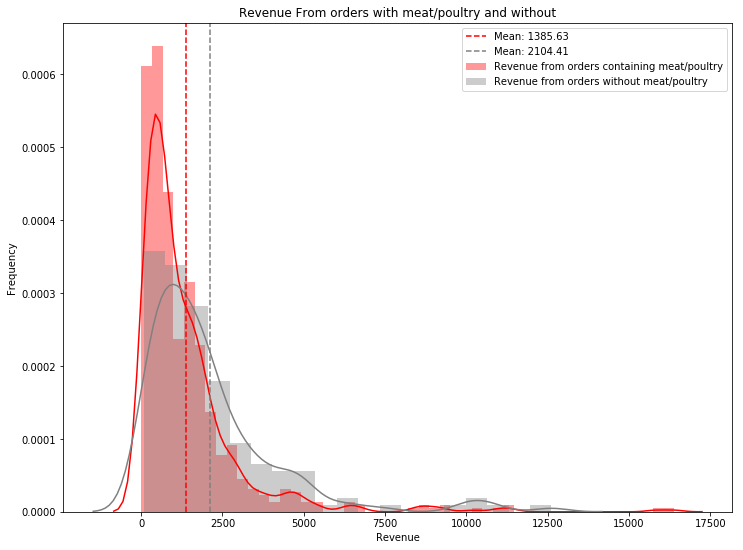

In [122]:
# distribution for control & treatment
plt.figure(figsize=(12,9))
sns.distplot(control3, label="Revenue from orders containing meat/poultry", color="red")
sns.distplot(treatment3, label="Revenue from orders without meat/poultry ", color="grey")
plt.axvline(control3.mean(), label="Mean: "+str(round(control3.mean(), 2)), color="red", linestyle='--')
plt.axvline(treatment3.mean(), label="Mean: " +str(round(treatment3.mean(), 2)), color="grey", linestyle='--')
plt.title("Revenue From orders with meat/poultry and without")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.legend()

In [123]:
# Kolmogorov-Smirnov Test for normality
(stats.kstest(control3, 'norm'))

KstestResult(statistic=1.0, pvalue=0.0)

In [124]:
(stats.kstest(treatment3, 'norm'))

KstestResult(statistic=1.0, pvalue=0.0)

The p-values for both of our samples are below 0.05, meaning we can reject the null hypothesis and conclude that our samples' distributions are no identical to a normal distribution. We can also visually confirm using the histogram above. However, since we are working with such a large sample size (n > 150), we can still move on to check variance and perform a T-test. 

In [125]:
# Levene Test (check for variance)
if stats.levene(control3,treatment3)[1]<0.05:
    print('Input samples are not from populations with equal variances.')
else:
    print('Input samples are from populations with equal variances.')

Input samples are not from populations with equal variances.


Because our two populations *do not have equal variances*, we shall proceed our hypothesis testing using Welch's Test (Two-Sample and One-Tailed)

In [126]:
welch_t(control3, treatment3)

T-statistic: 3.9662667148149002
Degrees of Freedom: 214.04378343974287
P-value: 4.9785478635322455e-05
Decision: Reject Null Hypothesis


In [141]:
# effect size using Cohen's D
effect_size3 = Cohen_d(control3, treatment3)
print("Effect size:", effect_size3)

# small = 0.2
# medium = 0.5
# large = 0.8

Effect size: -0.3939506386151902


In [130]:
# check power 
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=effect_size3, nobs1=150, alpha=.05)

0.9251699739935925

**Results**: With a p-value below our alpha of 0.05 and a power of greater than 0.8, we can *reject the null hypothesis and accept the alternative hypotheis*. It appears that orders without meat/poultry do generate more revenue than orders with. The small effect size, does mean that the effect may not be very pronounced. Should be further explored.<br>
That being said, despite generating more revenue per order, there were about 3 times as many orders with meat/poultry than without. With our new insights, it may be time to shift marketing strategies to acquire more customers how do not order meat/poultry with their orders. This may be a potential way to boost revenues overall for the company.

<h2> 4. Does shipping from the same region as the supplier have an effect on freight? </h2>

Checking on operations is a great way to find inefficiencies to decrease costs and increase profits. Optomizing shipping from our suppliers seemes like a great place to explore and find ways to make more efficient. 

> **Control** : Freight costs when shipping not from the same region as supplier
>
> **Treatment** : Freight costs when shipping from the same region as supplier
>
>>$H_{0}:$ Freight costs will be the same for all orders. $\mu_0  = \mu_1 $
>
>> $H_{1}:$ Freight costs will not be the same for orders when shipped from the same region as the supplier. $\mu_0 \neq \mu_1 $
>
> Significance Level: $\alpha = 0.05$ (Probability of a Type I error)

In [87]:
cur.execute('''SELECT Supplier.Region, o.ShipRegion, o.freight
                            FROM [Order] AS o
                          JOIN OrderDetail ON o.ID == OrderDetail.OrderID
                          JOIN Product ON OrderDetail.ProductID == Product.ID
                          JOIN Supplier ON Supplier.ID == Product.SupplierID;''')
freight = pd.DataFrame(cur.fetchall())
freight.columns = [x[0] for x in cur.description]
freight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
Region        2155 non-null object
ShipRegion    2155 non-null object
Freight       2155 non-null float64
dtypes: float64(1), object(2)
memory usage: 50.6+ KB


In [89]:
# control (shipping not from same region)
control4 = freight[freight['Region'] != freight['ShipRegion']]['Freight']
control4.describe()

count    1856.000000
mean       92.745113
std       127.982115
min         0.020000
25%        18.635000
50%        52.920000
75%       112.490000
max      1007.640000
Name: Freight, dtype: float64

In [88]:
# treatment (shipping from same region)
treatment4 = freight[freight['Region'] == freight['ShipRegion']]['Freight']
treatment4.describe()

count     299.000000
mean      117.629331
std       159.332480
min         0.150000
25%        23.290000
50%        64.560000
75%       147.060000
max      1007.640000
Name: Freight, dtype: float64

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


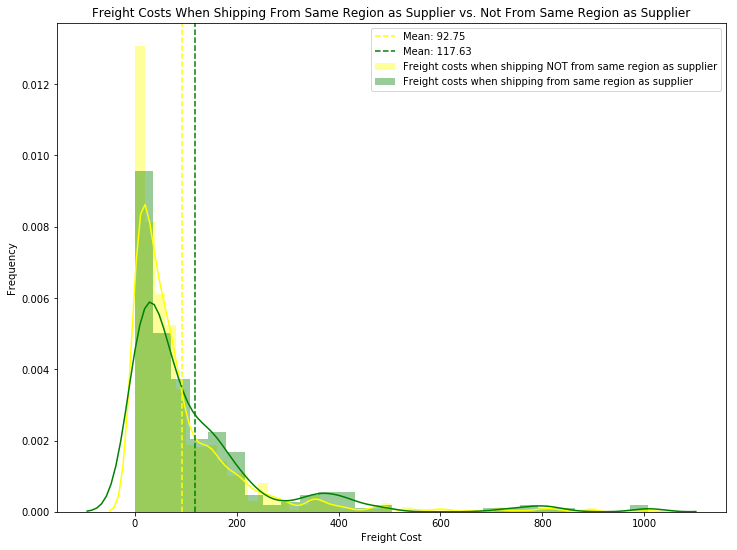

In [134]:
# distribution for control & treatment
plt.figure(figsize=(12,9))
sns.distplot(control4, label="Freight costs when shipping NOT from same region as supplier", color="yellow")
sns.distplot(treatment4, label="Freight costs when shipping from same region as supplier", color="green")
plt.axvline(control4.mean(), label="Mean: "+str(round(control4.mean(), 2)), color="yellow", linestyle='--')
plt.axvline(treatment4.mean(), label="Mean: " +str(round(treatment4.mean(), 2)), color="green", linestyle='--')
plt.title("Freight Costs When Shipping From Same Region as Supplier vs. Not From Same Region as Supplier")
plt.xlabel("Freight Cost")
plt.ylabel("Frequency")
plt.legend()

In [136]:
# Kolmogorov-Smirnov Test for normality
(stats.kstest(control4, 'norm'))

KstestResult(statistic=0.9448088882659249, pvalue=0.0)

In [135]:
# Kolmogorov-Smirnov Test for normality
(stats.kstest(treatment4, 'norm'))

KstestResult(statistic=0.9583280255240479, pvalue=0.0)

The p-values for both of our samples are below 0.05, meaning we can reject the null hypothesis and conclude that our samples' distributions are no identical to a normal distribution. We can also visually confirm using the histogram above. However, since we are working with such a large sample size (n > 200), we can still move on to check variance and perform a T-test. 

In [137]:
# Levene Test (check for variance)
if stats.levene(control4,treatment4)[1]<0.05:
    print('Input samples are not from populations with equal variances.')
else:
    print('Input samples are from populations with equal variances.')

Input samples are not from populations with equal variances.


Because our two populations *do not have equal variances*, we shall proceed our hypothesis testing using Welch's Test (Two-Sample and Two-Tailed)

In [138]:
welch_t(control4, treatment4, two_sided=True)

T-statistic: 2.570292317793137
Degrees of Freedom: 362.538552340464
P-value: 0.010559865355354914
Decision: Reject Null Hypothesis


In [140]:
# effect size using Cohen's D
effect_size4 = Cohen_d(control4, treatment4)
print("Effect size:", effect_size4)

# small = 0.2
# medium = 0.5
# large = 0.8

Effect size: -0.18741657844925197


In [143]:
# check power 
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=effect_size4, nobs1=200, alpha=.05)

0.4640801554626206

**Result**: We did reject the null hypothesis and accepted the alternative that freight costs are not the same when shipped from the same region. However the low effect size indicates that while our results are statistically significant, the difference may be trivial. Additionally we had a power of less than 0.8, indicating that we may have too small a sample size. Regardless there is enough evidence to further investigate the freight cost based on regions. 